In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import pickle
from google.colab import drive
from keras.regularizers import L1L2
from keras import backend as K

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MAX_NUM_WORDS = 50000
EMBEDDING_DIM = 200
MAX_SEQUENCE_LENGTH = 100

In [ ]:
def create_tokenizer(input_data, save_path):
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
    lower=True)
  tokenizer.fit_on_texts(input_data)
  save_tokenizer(tokenizer, save_path)
  return tokenizer

def save_tokenizer(tokenizer, filename):
  with open(filename, 'wb') as f:
    pickle.dump(tokenizer, f,
    protocol=pickle.HIGHEST_PROTOCOL)

def load_tokenizer(filename):
  with open(filename, 'rb') as f:
    tokenizer = pickle.load(f)
    return tokenizer


In [ ]:
def plot_model(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'],
    label='test')
  plt.legend()
  plt.show()

  plt.title('F1 score')
  plt.plot(history.history['f1_m'], label='train')
  plt.plot(history.history['val_f1_m'],
    label='test')
  plt.legend()
  plt.show()

In [ ]:
def evaluate(model, X_test, Y_test, le):
  Y_pred = model.predict(X_test)
  Y_pred = np.argmax(Y_pred, axis=1)
  print(classification_report(Y_test, Y_pred))

In [ ]:
def transform_text(tokenizer, texts):
  sequences = tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Works/NLP/Project_1/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Works/NLP/Project_1/test.csv")

In [ ]:
nltk.download(['stopwords', 'wordnet'])
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    # punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    # for p in punctuations:
    #     text = text.replace(p,'') #Removing punctuations

    text = [word for word in text.split() if word not in sw]

    # text = [lemmatizer.lemmatize(word) for word in text]

    text = " ".join(text) #removing stopwords and lemmatizing

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocess(df):
  df['text'] = df['text'].apply(lambda x: clean_text(x))
  df = df.fillna('No information', axis=1)
  #df['text'] = 'KEYWORD= ' + df.keyword + '; LOCATION= ' + df.location + '; TEXT= ' + df.text
  df.drop(["id", "keyword", "location"], inplace=True, axis=1)
  return df

In [ ]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [ ]:
df_train.isna().sum()

text      0
target    0
dtype: int64

In [ ]:
df_train.shape

(7613, 2)

<Axes: >

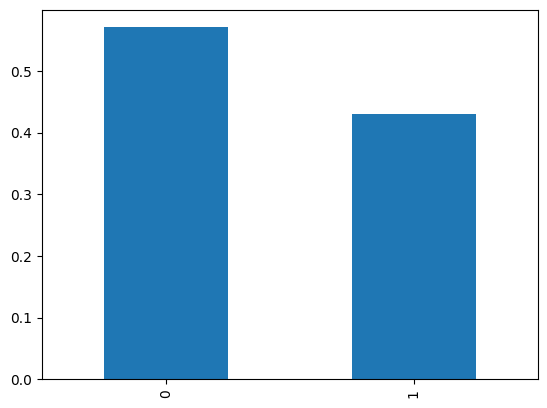

In [ ]:
df_train['target'].value_counts(normalize=True).plot.bar()

In [ ]:
tokenizer = create_tokenizer(df_train['text'].values, 'disaster_tokenizer.pickle')
X = transform_text(tokenizer, df_train['text'].values)
Y = df_train['target'].values.astype('int')
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()
optimizer = tf.keras.optimizers.Adam(5e-5)
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM,
  input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
               kernel_regularizer= L1L2(l1=0.01, l2=0.0))))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#Standard for multiclass classification
loss='binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          10000000  
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 200)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           64064     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 33, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                      

In [ ]:
X_train

array([[    0,     0,     0, ...,     2,     1, 17157],
       [    0,     0,     0, ...,   380,   141, 13576],
       [    0,     0,     0, ...,    10,    22, 16974],
       ...,
       [    0,     0,     0, ...,  8618,    21,    19],
       [    0,     0,     0, ...,     1, 22079, 22080],
       [    0,     0,     0, ...,     1, 21471,    27]], dtype=int32)

In [ ]:
Y_train

array([1, 0, 1, ..., 0, 1, 1])

In [30]:
epochs = 20
batch_size = 32

es = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-5)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[es], shuffle=True)
model.save('/content/drive/MyDrive/Works/NLP/Project_1/disaster_model_4.keras')

Epoch 1/20
153/153 [==============================] - 72s 417ms/step - loss: 22.0682 - accuracy: 0.5714 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 20.8441 - val_accuracy: 0.5616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
153/153 [==============================] - 61s 401ms/step - loss: 19.6911 - accuracy: 0.5714 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 18.5398 - val_accuracy: 0.5616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
153/153 [==============================] - 61s 401ms/step - loss: 17.4546 - accuracy: 0.5712 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 16.3719 - val_accuracy: 0.5616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
153/153 [==============================] - 61s 397ms/step - loss: 15.3523 - accuracy: 0.5741 - f1_m: 0.0

In [31]:
loss, accuracy, f1_score,_,_ = model.evaluate(X_val, Y_val, verbose=0)
print("F1 score: ", f1_score)

F1 score:  0.7481586933135986


48/48 [==============================] - 4s 45ms/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



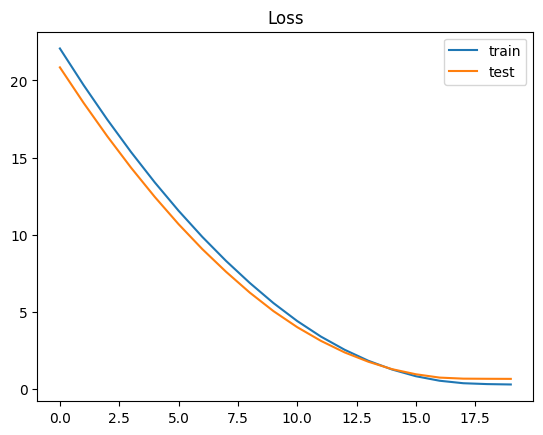

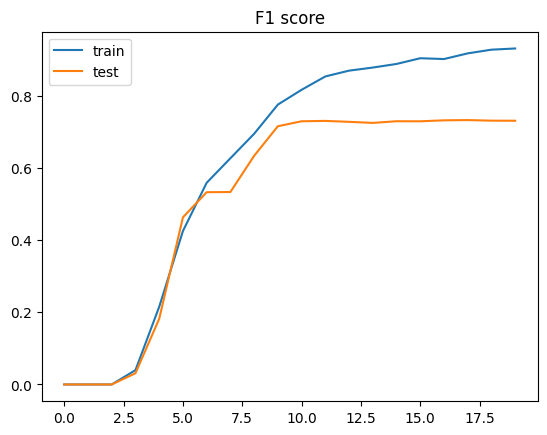

In [32]:
Y_pred = model.predict(X_val)
Y_pred = Y_pred.round().astype('int').flatten()
print(classification_report(Y_val, Y_pred))
plot_model(history)

In [33]:
# Preparing submission
tokenizer = load_tokenizer('disaster_tokenizer.pickle')

X_test = df_test["text"]
X_test_cv = transform_text(tokenizer, X_test)

# generate predictions
predictions = model.predict(X_test_cv)
predictions = predictions.round().astype('int').flatten()
predictions

102/102 [==============================] - 5s 45ms/step


array([0, 1, 1, ..., 1, 1, 0])

In [34]:
predicted_df = df_test.copy()
predicted_df['target'] = predictions

In [35]:
predicted_df

,text,target
0,happened terrible car crash,0
1,"heard earthquake different cities, stay safe e...",1
2,"forest fire spot pond, geese fleeing across st...",1
3,apocalypse lighting. spokane wildfires,0
4,typhoon soudelor kills china taiwan,1
...,...,...
3258,earthquake safety los angeles safety fasteners...,0
3259,storm ri worse last hurricane. city amp others...,1
3260,green line derailment chicago http t.co utbxlc...,1
3261,meg issues hazardous weather outlook hwo http ...,1


In [36]:
submission_df = pd.read_csv(f'/content/drive/MyDrive/Works/NLP/Project_1/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":predictions})
submission.to_csv('/content/submission.csv', index=False)